In [1]:
####### loading module
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk

import zipfile
from read_roi import read_roi_zip
import read_roi
from collections import OrderedDict

from skimage.io import imread, imshow
from skimage import *

import pandas as pd

########################### 
# fuction of scaling pixel value using window level & widow width
def win_scale(data, wl, ww, dtype, out_range):
    """
    Scale pixel intensity data using specified window level, width, and intensity range.
    """
    
    data_new = np.empty(data.shape, dtype=np.double)
    data_new.fill(out_range[1]-1)
    
    data_new[data <= (wl-ww/2.0)] = out_range[0]
    
    data_new[(data>(wl-ww/2.0))&(data<=(wl+ww/2.0))] = ((data[(data>(wl-ww/2.0))&(data<=(wl+ww/2.0))]-(wl-0.5))/(ww-1.0)+0.5)*(out_range[1]-out_range[0])+out_range[0]
    
    data_new[data > (wl+ww/2.0)] = out_range[1]-1
    
    return data_new.astype(dtype)

In [2]:
# Setting data path
dataPath = '../data'
savePath = '../npy'

numpy shape= image: (4, 512, 512, 1), mask: (4, 512, 512, 1)
Input data 00100000002 to array layer 0
Input data 00100000003 to array layer 1
Input data 00200000002 to array layer 2
Input data 00200000003 to array layer 3


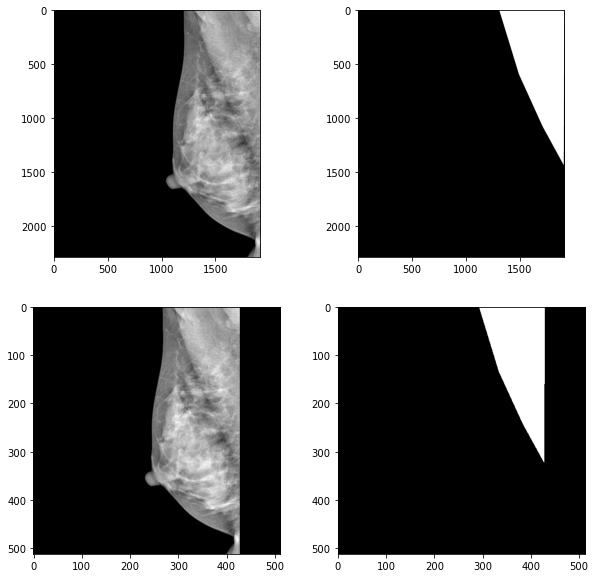

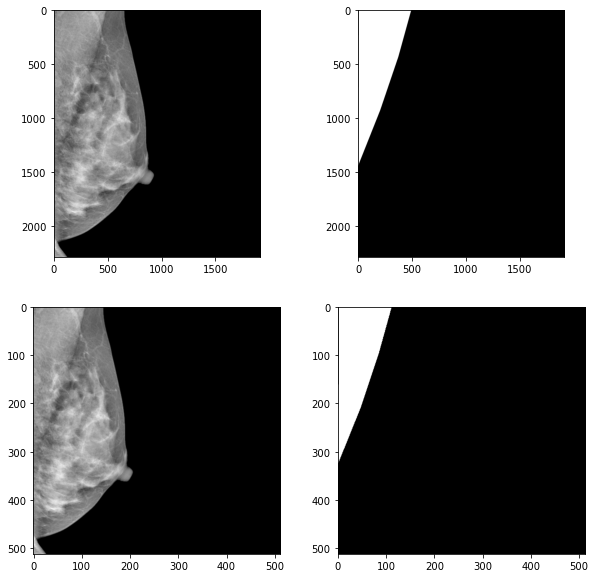

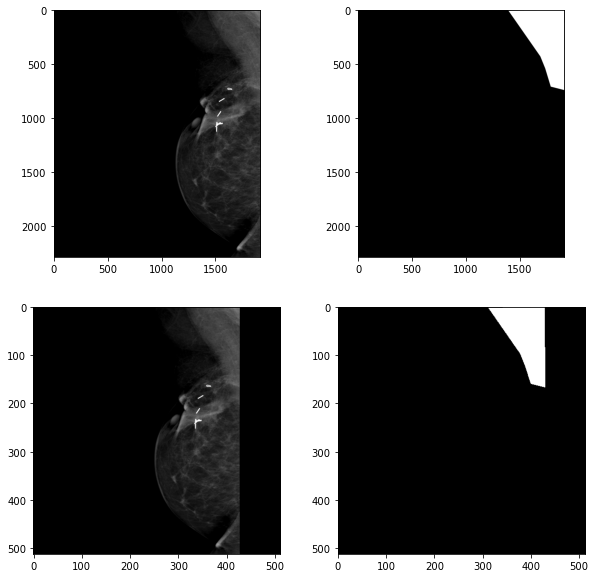

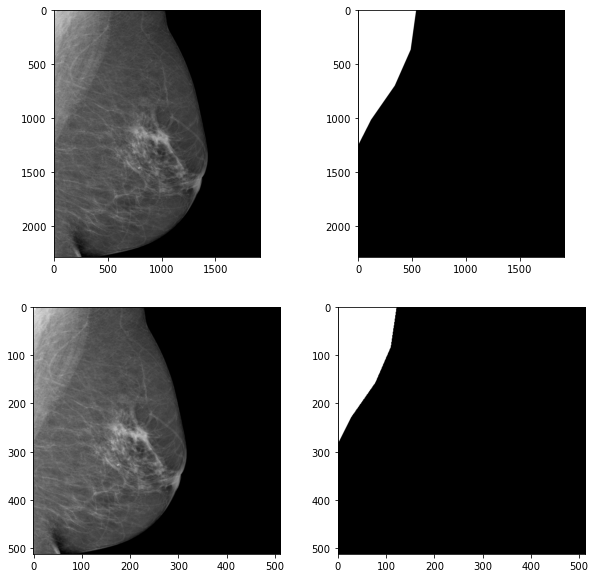

In [3]:
##### Making image and mask data for training
imageSize=512  
channel = 1

# loading dicom files
dcmList= sorted(glob.glob(dataPath+'/*.dcm'))

# making empty arrays
imgnpy = np.zeros((len(dcmList),imageSize,imageSize,1), dtype=np.uint8)
msknpy = np.zeros((len(dcmList),imageSize,imageSize,1), dtype=np.uint8)

print('numpy shape= image: {}, mask: {}'.format(imgnpy.shape, msknpy.shape))  #Checking shape of arrays

# input each image and mask from roi file to empty array
for dl in range(len(dcmList)):
    
    file_num= dcmList[dl].split('\\')[-1].split('.')[0]
    print('Input data {} to array layer {}'.format(file_num, dl))

    # read dicom to Image data using sitk
    dcm_dcm = sitk.ReadImage(dcmList[dl])
    dcm_img = sitk.GetArrayFromImage(dcm_dcm)[0]

    WL = dcm_dcm.GetMetaData('0028|1050')
    WW = dcm_dcm.GetMetaData('0028|1051')

    WL = int(WL.split('\\')[0])
    WW = int(WW.split('\\')[0])
    
    dcm_scaled = win_scale(dcm_img, WL, WW, np.uint8, (0, 255))

    # Resizing array for uniform size of data
    scale = imageSize/dcm_scaled.shape[0]
    
    resized = cv2.resize(dcm_scaled, dsize=(round(scale*dcm_scaled.shape[1]),512), interpolation=cv2.INTER_AREA)
    imgnpy[dl][:512,:round(scale*dcm_scaled.shape[1]),0] = resized[:,:]

    # loading .roi format files
    roiList= sorted(glob.glob(dcmList[dl][:dcmList[dl].rindex('.')]+'*.roi'))
    black=np.zeros((dcm_scaled.shape[0],dcm_scaled.shape[1]),dtype=np.uint8) # for checking

    # drawing rois to zero image 
    for rs in range(len(roiList)):
        rois = read_roi.read_roi_file(roiList[rs]) # loading roi file
        odKey = list(OrderedDict(rois).keys())

        locset= np.ndarray((1,int(rois[odKey[0]]['n']),2), dtype=int)
        check_loc= np.ndarray((1,int(rois[odKey[0]]['n']),2), dtype=int) # for checking

        for n in range(0,int(rois[odKey[0]]['n'])):
            locset[0][n]= (round(rois[odKey[0]]['x'][n]*scale), round(rois[odKey[0]]['y'][n]*scale))
            check_loc[0][n]= (rois[odKey[0]]['x'][n], rois[odKey[0]]['y'][n]) # for checking

        cv2.fillPoly(msknpy[dl], locset,(255,255,255))
        cv2.fillPoly(black,check_loc,(255,255,255)) # for checking

######## Checking each of image and mask
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.title('image before resize')
    plt.imshow(dcm_scaled, cmap='gray')
    plt.subplot(2,2,2)
    plt.title('mask before resize')
    plt.imshow(black, cmap='gray')   
    plt.subplot(2,2,3)
    plt.title('image after resize')
    plt.imshow(imgnpy[dl], cmap='gray')
    plt.subplot(2,2,4)
    plt.title('mask before resize')
    plt.imshow(msknpy[dl], cmap='gray')

###Saving numpy arrays of images and masks to npy file
np.save(savePath+'/images.npy',imgnpy)
np.save(savePath+'/mask.npy',msknpy)


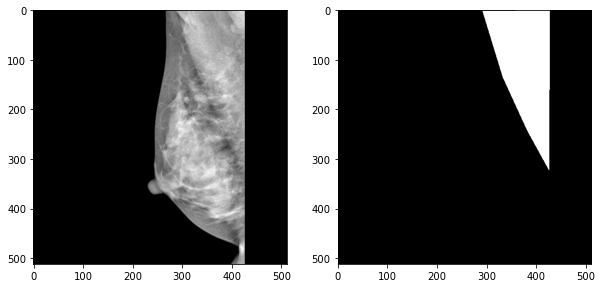

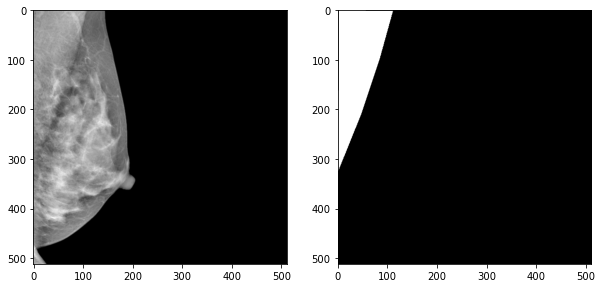

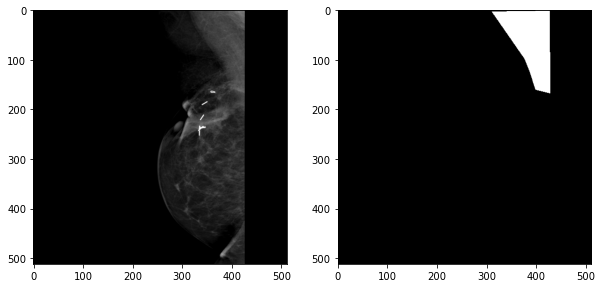

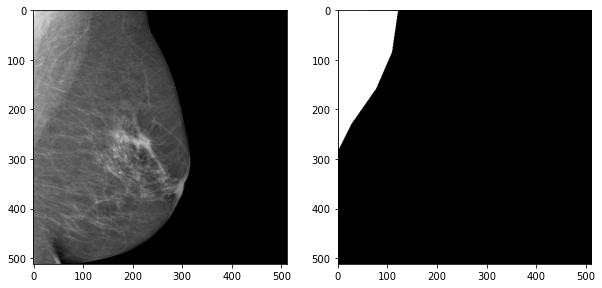

In [4]:
for nps in range(len(imgnpy)):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(imgnpy[nps], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(msknpy[nps], cmap='gray')   